<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 4.

# 0. Load libraries

In [30]:
from matplotlib import  pyplot as plt
import numpy as np
from imageio import imread
import pandas as pd
from time import time as timer

import tensorflow as tf
import plotly.graph_objects as go

%matplotlib inline
from PIL import Image
from matplotlib import animation
from matplotlib import cm
from IPython.display import HTML
from sklearn.datasets import make_blobs

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

In [2]:
import os
import tarfile

In [3]:
import os
import tensorflow as tf
import tarfile
import os
from packaging import version
import shutil
import sys 

def download_and_extract_data(
    url="https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz",
    target_dir="data",
    fname="colab_material.tgz",
    update_folder=False
):
    """Download and extract a tar.gz dataset into target_dir."""
    
    if update_folder and os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    if not os.path.exists(target_dir):
        cache_dir = os.path.abspath(".")

        if version.parse(tf.__version__) >= version.parse("2.13.0"):
            # new behavior: fname must be only a filename
            path = tf.keras.utils.get_file(
                fname=fname,
                origin=url,
                cache_dir=cache_dir
            )
        else:
            # old behavior: can pass full path
            path = tf.keras.utils.get_file(
                fname=os.path.join(cache_dir, fname),
                origin=url
            )
        # extract tar into target_dir
        with tarfile.open(path, "r:gz") as tar:
            tar.extractall(target_dir)
    else:
        print('Data already present. Use update_folder = True to overwrite/update if desired.')
    return os.path.abspath(target_dir)

data_path = download_and_extract_data(update_folder=False)
sys.path.append(data_path)
print("Data available at:", data_path)

Data already present. Use update_folder = True to overwrite/update if desired.
Data available at: /Users/aris.marcolongo/DSF5_tests/data


In [4]:
from utils.routines import *

# 1. Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [ ]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

In [ ]:
x, y = get_linear(n_d=1, sigma=1)
plt.plot(x[:, 0], y, '*')
plt.show()

In [ ]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=10)
plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [5]:
def house_prices_dataset(return_df=False, return_df_xy=False, price_max=400000, area_max=40000, data_path='/content/data'):
  path = os.path.join(data_path, 'data/AmesHousing.csv')

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False,  )

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else ((x, y, (df_X, df_Y)) if return_df_xy else (x,y))

In [ ]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

In [ ]:
df.describe()

In [ ]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

In [ ]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

In [ ]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])

transformation = [[0.4, 0.2], [-0.4, 1.2]]  # affine transformation matrix
x = np.dot(x, transformation)               # applied to point coordinated to make blobs less separable

colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()



## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

In [ ]:
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 6. Weather dataset

This is a weather time series [dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the Max Planck Institute for Biogeochemistry
It contains weather reacord for 8 years of observation.

In [ ]:
def get_weather_df():
  # inspired by https://www.tensorflow.org/tutorials/structured_data/time_series

  # download and extract dataset
  zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
  csv_path, _ = os.path.splitext(zip_path)

  # load into pandas df
  df = pd.read_csv(csv_path)

  # dataset contains records every 10 min, we use hourly records only, thus
  # slice [start:stop:step], starting from index 5 take every 6th record
  df = df[5::6]

  # replace errors in wind velocity to 0
  wv = df['wv (m/s)']
  bad_wv = wv == -9999.0
  wv[bad_wv] = 0.0

  max_wv = df['max. wv (m/s)']
  bad_max_wv = max_wv == -9999.0
  max_wv[bad_max_wv] = 0.0

  # obtain timestamps from text time format
  date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  # genarate cyclic features for year and day
  day = 24*60*60
  year = (365.2425) * day

  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  return df

In [ ]:
weather_df = get_weather_df()

In [ ]:
weather_df.head()

In [ ]:
weather_df.describe().T

In [ ]:
plt.plot(weather_df['Year cos'])
plt.plot(weather_df['Year sin'])

In [ ]:
plt.plot(weather_df['Day cos'][:7*24])
plt.plot(weather_df['Day sin'][:7*24])

In [ ]:
def gen_future_T_dataset(X_len=24, Y_offset=48,
                         X_features=['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
                         Y_features='T (degC)',
                         standardize=True,
                         oversample=10
                         ):
  """
  Generates pairs of input-label, using sequence of `X_len` samples as input
  and value at offset `Y_offset` from start of this sequence as label.
  Sample sequnces arte taken at random positions throughout the dataset.
  Number of samples is obtained assuming non-overlaping wondows.
  Oversampling factor allows to increase this value.

  Args:
    X_len (int): length of sample sequence
    Y_offset (int): offset to the target value from the sequence start
    X_features (list or str): features to be used as input
    Y_features (list or str): features to be used as labels
    standardize (Bool): flag whether to standardize the columns
    oversample (int): increases number of samples by this factor wrt baseline
                      n = len(df) // (Y_offset+1)
  """
  weather_df = get_weather_df()

  if standardize:
    mean = weather_df.mean()
    std = weather_df.std()
    weather_df = (weather_df - mean) / std

  df_X = weather_df[X_features]
  df_Y = weather_df[Y_features]

  n_records = len(df_X)
  sample_len = Y_offset+1
  n_samples = int((n_records-sample_len)//sample_len*oversample)
  offsets = np.random.randint(0, n_records-sample_len, size=n_samples)
  offsets.sort()

  X = []
  Y = []
  for o in offsets:
    X.append(np.array(df_X[o:o+X_len]))
    Y.append(np.array(df_Y[o+Y_offset:o+Y_offset+1]))

  X = np.stack(X)
  Y = np.concatenate(Y)

  return X, Y

In [ ]:
x, y = gen_future_T_dataset()

In [ ]:
x.shape, y.shape

In [ ]:
for f,fn in enumerate(['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos']):
  plt.figure(figsize=(5*(1+(f==1)), 4))
  for s in range(10):
    plt.plot(x[s, :, f])
    if f==1:
      plt.scatter(48, y[s], color=plt.gca().lines[-1].get_color())
  plt.title(fn)
  plt.show()

# 2. Neural Networks Introduction

## 1. Perceptron

(Artificial) Neural network consists of layers of neurons. Artificial neuron, or perceptron, is in fact inspired by a biological neuron.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/Perceptron.png" alt="drawing" width="30%"/>

Such neuron first calculates the linear transformation of the input vector $\bar x$:
$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$ where $\bar W$ is vector of weights and $b$ - bias.



This is effectively linear regression. You can combine those parallely to make a multidimensional prediction, e.g.:

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/2Perceptrons.png" alt="drawing" width="30%"/>

## 2. Nonlinearity

Combining multiple such objects performing linear transformation sequentially would not bring any additional benefit, as the combined output would still be a linear combination of the inputs.

What gives actual power to neurons, is that they additionally perform the nonlinear transformation of the result using activation function $f$ $$y = f(z)$$

The most commonly used non-linear transformations are:

In [ ]:
def ReLU(z):
  return np.clip(z, a_min=0, a_max=np.max(z))
def SELU(z, a=1):
  p = np.clip(z, a_min=0, a_max=np.max(z))
  n = np.clip(z, a_min=np.min(z), a_max=0)
  return p + (np.exp(n)-1) * a
def LReLU(z, a=0.1):
  return np.clip(z, a_min=0, a_max=np.max(z)) + np.clip(z, a_min=np.min(z), a_max=0) * a
def sigmoid(z):
  return 1/(1 + np.exp(-z))
def step(z):
  return np.heaviside(z, 0)
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
z = np.linspace(-10, 10, 100)
ax[0].plot(z, ReLU(z))
ax[0].set_title('Rectified Linear Unit (LU)')
ax[1].plot(z, LReLU(z))
ax[1].set_title('Leaky Rectified LU')
ax[2].plot(z, SELU(z))
ax[2].set_title('Scaled Exponential LU')
ax[3].plot(z, sigmoid(z))
ax[3].set_title(r'$\sigma$(z)=$\frac{1}{1+e^z}$')
ax[4].plot(z, np.tanh(z))
ax[4].set_title('Hyperbolic tangent');
ax[5].plot(z, step(z))
ax[5].text(-6, 0.5, 'NOT USED', size=19, c='r')
ax[5].set_title('Step function');
for axi in ax:
  axi.set_xlabel('z')
plt.show()

And the reason we don't use a simple step function, is that it's everywhere either not differentiable or its derivative is zero.

The last nonlinearity to mention here is *softmax*:
$$y_i = SoftMax(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

While each $z_i$ can have any value, the corresponding $y_i\in[0,1]$, and $\sum_i y_i=1$, just like probabilities!

While these $y_i$ are only pseudo-probabilities, this nonlinearity allows one to model probabilities, e.g. of a data-point belonging to a certain class.






## 3. Fully connected net

In a fully connected neural network each layer is a set of N neurons, performing different transformations of all the same layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]_{i=1..N}$: $$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since output of each layer forms input of next layer, one can write for layer $l$ (upper index denotes layer): $$x^l_j = f(\bar W^l_j \cdot \bar x^{l-1} + b^l_j)$$ where $\bar x^0$ is network's input vector.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/MLP.png" alt="drawing" width="50%"/>


## 4. Loss function

The last part of the puzzle is the measure of network performance, which is used to optimize the network's parameters $W^l_j$ and $b^l_j$.
Denoting the network's output for an input $x_i$ as $\hat y_i=\hat y_i(x_i)$ and given the label $y_i$:

1. In case of regression loss shows "distance" from target values:
* L2 (MSE): $L = \sum_i (y_i-\hat y_i)^2$
* L1 (MAE): $L = \sum_i |y_i-\hat y_i|$

1. In case of classification we can use cross-entropy, which shows "distance" from target distribution:
$$L = - \sum_i \sum_c y_{i,c} \log(\hat y_{i,c})$$
Here $\hat y_{i,c}$ - pseudo-probability of $x_i$ belonging to class $c$ and $y_{i,c}$ uses 1-hot encoding:

$$y_{i,c}=
\begin{cases}
    1,& \text{if } x_i \text{ belongs to class } c\\
    0,              & \text{otherwise}
\end{cases}$$


## 5. Training

Training of neural networks is performed iteratively. The weights  $W^l_j$ and $b^l_j$ are updated on each iteration of training according to the value of the derivative of the loss function with respect to corresponding parameter:
$$W^l_j \rightarrow W^l_j - \lambda \frac{\partial L}{\partial W^l_j }$$
$$b^l_j \rightarrow b^l_j - \lambda \frac{\partial L}{\partial b^l_j },$$

This is Gradient Descent optimization with learning rate $\lambda$. The partial derivatives are calculated by the chain law, and this approach is known as [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

In practice often for each iteration the loss $L$ is evaluated not on all samples, but on a sub-sample, so-called *minibatch* (sometimes - just batch). In most cases the sample order and selection for each minibatch is performed at random rendering this approach to be stochastic (thus it's called [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)). One iteration through all training data in minibatches is called *epoch*.

# 3. Regression with neural network

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. 1D input

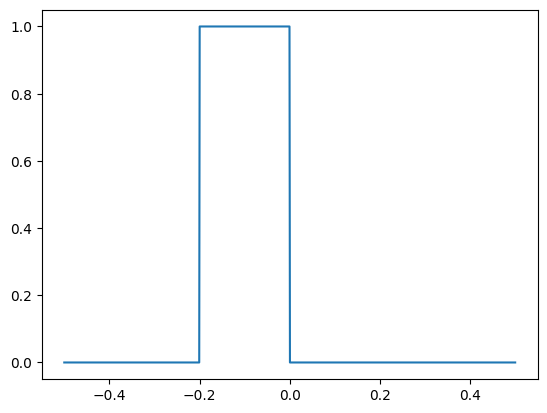

In [46]:
x = np.linspace(0, 10, num=1000)
y = ((x>3)*(x<5)).astype(np.float32)

#y = x**3/500 + np.sin(x) #+ np.sin((10-x)**2)

x /= 10
x -= 0.5
plt.plot(x, y);

In [47]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1,)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation=None),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1)                 0         
                                                                 
 dense_4 (Dense)             (None, 100)               200       
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 301 (1.18 KB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
class saving_pred(tf.keras.callbacks.Callback):
  def __init__(self):
    self.y_preds = []

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 10 == 0:
        y_p = model.predict(x).flatten()
        #print('\n', epoch, y_p.shape, '\n\n')
        self.y_preds.append(y_p)

In [49]:
saving_callback = saving_pred()
hist = model.fit(x, y,
                 epochs=300, batch_size=100, callbacks=[saving_callback])

Epoch 1/300
10/10 [==============================] - 0s 8ms/step - loss: 0.2321 - mse: 0.1899
Epoch 2/300
10/10 [==============================] - 0s 740us/step - loss: 0.2067 - mse: 0.1826
Epoch 3/300
10/10 [==============================] - 0s 674us/step - loss: 0.2008 - mse: 0.1736
Epoch 4/300
10/10 [==============================] - 0s 660us/step - loss: 0.1992 - mse: 0.1704
Epoch 5/300
10/10 [==============================] - 0s 639us/step - loss: 0.1991 - mse: 0.1699
Epoch 6/300
10/10 [==============================] - 0s 882us/step - loss: 0.1987 - mse: 0.1695
Epoch 7/300
10/10 [==============================] - 0s 703us/step - loss: 0.1975 - mse: 0.1685
Epoch 8/300
10/10 [==============================] - 0s 680us/step - loss: 0.1960 - mse: 0.1680
Epoch 9/300
10/10 [==============================] - 0s 756us/step - loss: 0.1953 - mse: 0.1665
Epoch 10/300
10/10 [==============================] - 0s 555us/step - loss: 0.1956 - mse: 0.1646
Epoch 11/300
10/10 [=====================

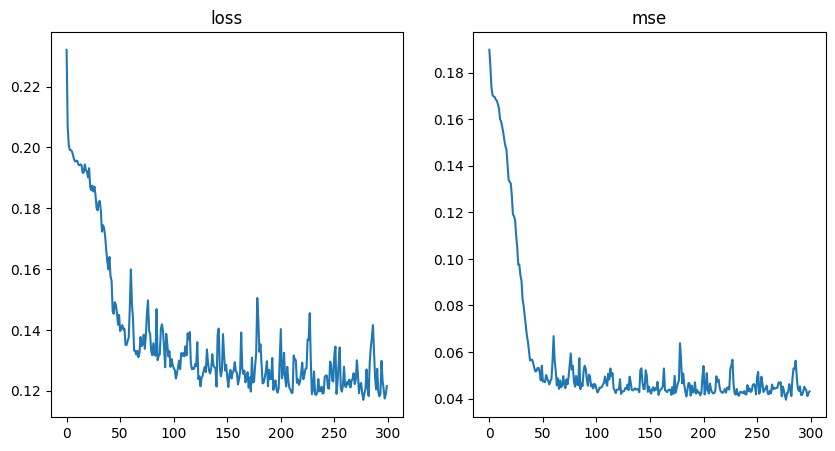

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].set_title('loss')
axs[1].plot(hist.epoch, hist.history['mse'])
axs[1].set_title('mse')
plt.show()

32/32 [==============================] - 0s 443us/step


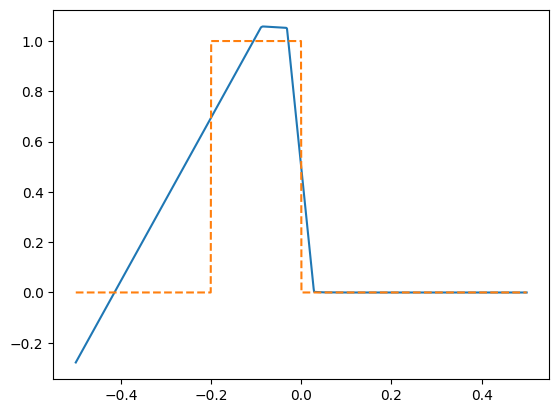

In [51]:
y_p = model.predict(x)
im = plt.plot(x, y_p)
im = plt.plot(x, y, '--')
plt.show()

In [52]:

%%capture
y_preds = saving_callback.y_preds

fig = plt.figure()
line = plt.plot(x, y_preds[0])
line2 = plt.plot(x, y)

def animate(i):
    y_p = y_preds[i]
    line[0].set_data((x, y_p))
    return line

ani = animation.FuncAnimation(fig, animate, frames=len(y_preds))

In [53]:
ani

## 2. 2D input

Here we will build a neural network to perform regression in 2D: we will fit $(x,y)$ pixel coordinates of an image to the pixel brightness at that location.

/var/folders/9k/nwfzztf91nv_r4g078nzmrfw0000gn/T/ipykernel_30709/1793758380.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_big = imread(url)


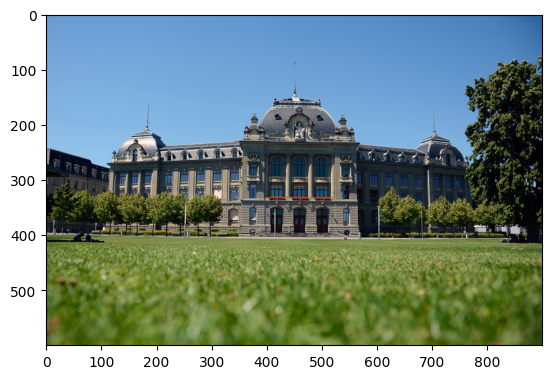

In [31]:
url = 'https://github.com/neworldemancer/DSF5/raw/master/figures/unibe.jpg'
image_big = imread(url)
image_big = image_big[...,0:3]/255
plt.imshow(image_big)
plt.show()

In [32]:
def subsample(im, factor):
  h, w = im.shape[:2]
  h = int(h/factor)
  w = int(w/factor)

  img = Image.fromarray((im*255).astype('uint8'))
  newimg = img.resize((w, h), Image.LANCZOS)
  return np.asarray(newimg)/255

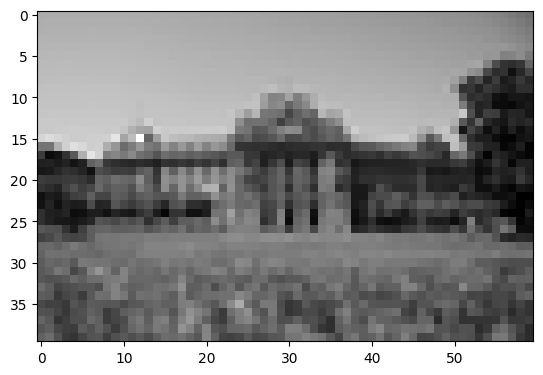

In [33]:
image = subsample(image_big, 15)
image = image.mean(axis=2, keepdims=True)
plt.imshow(image[...,0], cmap='gray')
plt.show()

In [34]:
h, w, c = image.shape

In [35]:
X0 = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
X = np.stack(X0, axis=-1).reshape((-1, 2))

Y = image.reshape((-1, c))
X.shape, Y.shape

((2400, 2), (2400, 1))

In [36]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 


Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
hist = model.fit(X, Y, epochs=500, batch_size=2048)

Epoch 1/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1858 - mse: 0.0446
Epoch 2/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1854 - mse: 0.0444
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1850 - mse: 0.0442
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1846 - mse: 0.0440
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1842 - mse: 0.0438
Epoch 6/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1838 - mse: 0.0436
Epoch 7/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1834 - mse: 0.0434
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1830 - mse: 0.0432
Epoch 9/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1826 - mse: 0.0431
Epoch 10/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1821 - mse: 0.0429
Epoch 11/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1817 

75/75 [==============================] - 0s 365us/step


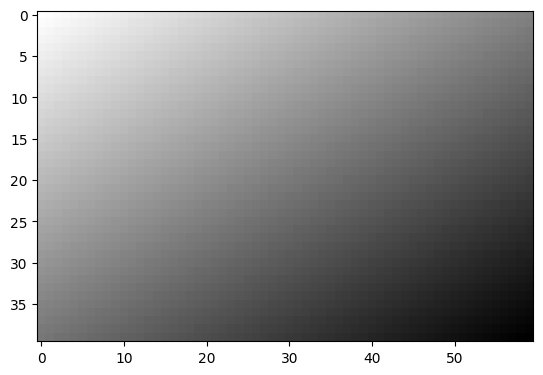

In [38]:
Y_p = model.predict(X)
Y_p = Y_p.reshape((h,w,c))
im = plt.imshow(Y_p[...,0], cmap='gray')
plt.show()

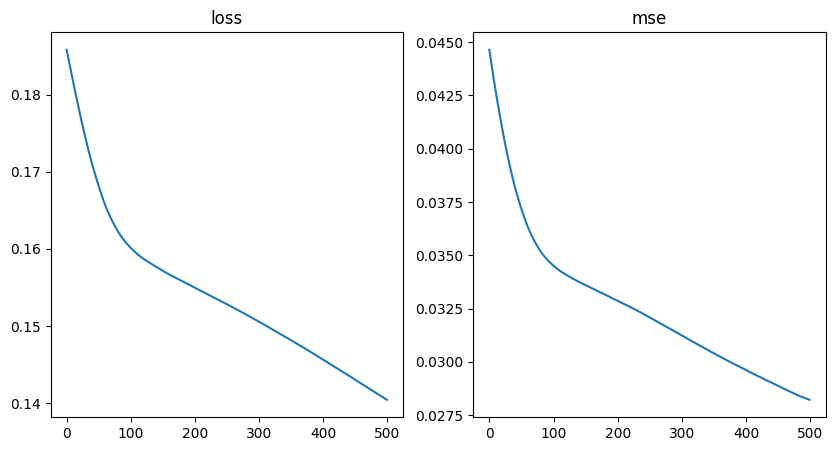

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].set_title('loss')
axs[1].plot(hist.epoch, hist.history['mse'])
axs[1].set_title('mse')
plt.show()

What is actually happening here? We fit an image with an $\mathbb{R}^2 \rightarrow \mathbb{R}$ funcion.

In [40]:

x = X[:,0].reshape((h,w))
y = X[:,1].reshape((h,w))
z = Y.reshape((h,w))
zp = Y_p.reshape((h,w))

ds = 2
x = subsample(x, ds)
y =-subsample(y, ds)
z = subsample(z, ds)
zp = subsample(zp, ds)

#surf = ax.plot_surface(x,y,z, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.3)
#surf = ax.plot_surface(x,y,zp, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.5)
#plt.show()

fig = go.Figure(data=[go.Surface(z=zp, x=x, y=y)])
fig.update_layout(autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Let's try the same with an RGB image:

In [ ]:
image = subsample(image_big, 15)
plt.imshow(image)
plt.show()

In [ ]:
h, w, c = image.shape
X = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
X = np.stack(X, axis=-1).reshape((-1, 2))

Y = image.reshape((-1, c))
X.shape, Y.shape

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

But now we will save images during the course of training, at first after 2, then 4, 8, 16, etc epochs.
(**Remember**: call to `model.fit` does NOT reinitialize trainable variables. Every time it continues from the previous state):

In [ ]:
class saving_pred(tf.keras.callbacks.Callback):
  def __init__(self, n_ep_pow):
    self.ims = []
    self.save_epochs = [0]+[2**i for i in range(n_ep_pow)]

  def on_epoch_end(self, epoch, logs=None):
    if epoch in self.save_epochs:
        Y_p = model.predict(X)
        Y_p = Y_p.reshape((h, w, c))
        self.ims.append(Y_p)

In [ ]:
n_ep_pow = 11
n_ep = 2**n_ep_pow+1

ims_callback = saving_pred(n_ep_pow)
hist = model.fit(X, Y, epochs=n_ep, batch_size=1*2048, verbose=0, callbacks=[ims_callback])

plt.plot(hist.epoch, hist.history['loss'])
plt.show()

In [ ]:
%%capture

ims = ims_callback.ims
fig = plt.figure()
im = plt.imshow(ims[0])

def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))

In [ ]:
ani

While the colors properly represent the target image, our model still poses very limited capacity, allowing it to effectively represent only 3 boundaries.

Let's upscale our model:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), # optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

In [ ]:
X.shape

In [ ]:
n_ep_pow = 13
n_ep = 2**n_ep_pow+1

ims_callback = saving_pred(n_ep_pow)
hist = model.fit(X, Y, epochs=n_ep, batch_size=1*2048, verbose=0, callbacks=[ims_callback])

plt.plot(hist.epoch, hist.history['loss'])
plt.show()

In [ ]:
%%capture

ims = ims_callback.ims
fig = plt.figure()
im = plt.imshow(ims[0])

def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))

In [ ]:
ani

We can also now render the fitted image at any resolution, by evaluating values in between of the original pixels:

In [ ]:
scale = 30
w_rend = w * scale
h_rend = h * scale
X_rend = np.meshgrid(np.linspace(0, 1, w_rend), np.linspace(0, 1, h_rend))
X_rend = np.stack(X_rend, axis=-1).reshape((-1, 2))

Y_rend = model.predict(X_rend)
Y_rend = Y_rend.reshape((h_rend, w_rend, c))

plt.imshow(Y_rend)

In [ ]:
plt.imshow(image_big)

In [ ]:
plt.imshow(image)

## EXERCISE 1. Regression on an image with Neural Network.

Load some image, downscale to a similar resolution, and train a deeper model, for example 5 layers, more parameters in widest layers.

In [ ]:
# 1. Load your image

# 2. build a deeper model

# 3. inspect the evolution

# 4. Classification of the F-MNIST dataset with neural network

## 0. Load data

We will create a model for classification of the F-MNIST dataset that we go acquainted with in previous sessions. We will normalize the inputs to have values $\in[0,1]$:

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 1. Building a neural network

In [ ]:
print(x_train[0].shape)

The size of each image sample $-\; 28\times28\text{ pixels}\;-\;$ defines the input size for our neural network. Network's output - probabilities of belonging to each of the 10 classes.

The following creates a 'model'. It is an object containing the neural network model itself - a simple 3-layer fully connected neural network, optimization parameters, as well as the interface for model training.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model summary provides information about the model's layers and trainable parameters

In [ ]:
model.summary()

## 2. Model training

The `fit` function is the interface for model training.
Here one can specify training and validation datasets, minibatch size, and the number of training epochs.

Here during training we also save the trained models checkpoints after each epoch of training.

In [ ]:
save_path = 'save/mnist_{epoch}.weights.h5'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model.fit(x=x_train, y=y_train,
                 epochs=50, batch_size=128,
                 validation_data=(x_test, y_test),
                 callbacks=[save_callback])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

Current model performance can be evaluated, e.g. on the test dataset:

---



In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

We can test trained model on an image:

In [ ]:
im_id = 0
y_pred = model(x_test)

y_pred_most_probable = np.argmax(y_pred[im_id])
print('true lablel: ', y_test[im_id],
      '; predicted: ',  y_pred_most_probable,
      f'({class_names[y_pred_most_probable]})')
plt.imshow(x_test[im_id], cmap='gray');

As well as inspect on which samples does the model fail:

In [ ]:
y_pred_most_probable_all = np.argmax(y_pred, axis=1)
wrong_pred_map = y_pred_most_probable_all!=y_test
wrong_pred_idx = np.arange(len(wrong_pred_map))[wrong_pred_map]

im_id = wrong_pred_idx[0]

y_pred_most_probable = y_pred_most_probable_all[im_id]
print('true lablel: ', y_test[im_id],
      f'({class_names[y_test[im_id]]})',
      '; predicted: ',  y_pred_most_probable,
      f'({class_names[y_pred_most_probable]})')
plt.imshow(x_test[im_id], cmap='gray');
plt.show()

## 3. Loading trained model

In [ ]:
model.load_weights('save/mnist_1.weights.h5')
model.evaluate(x_test,  y_test, verbose=2)

model.load_weights('save/mnist_12.weights.h5')
model.evaluate(x_test,  y_test, verbose=2)

model.load_weights('save/mnist_18.weights.h5')
model.evaluate(x_test,  y_test, verbose=2)

## 4. Inspecting trained variables

We can obtain the trained variables from model layers:

In [ ]:
l = model.get_layer(index=1)
w, b = l.weights

w = w.numpy()
b = b.numpy()
print(w.shape, b.shape)
w = w.reshape((28,28,-1)).transpose((2, 0, 1))

Let's visualize first 10:

In [ ]:
n = 10
fig, axs = plt.subplots(1, n, figsize=(4.1*n,4))
for i, wi in enumerate(w[:n]):
  axs[i].imshow(wi, cmap='gray')
  axs[i].set_title(class_names[i])
plt.show()

## 6. Inspecting gradients

We can also evaluate the gradients of each output with respect to an input:

In [ ]:
idx = 112
inp_v = x_train[idx:idx+1]  # use some image to compute gradients with respect to

inp = tf.constant(inp_v)  # create tf constant tensor
with tf.GradientTape() as tape:  # gradient tape for gradint evaluation
  tape.watch(inp)  # take inp as variable
  preds = model(inp) # evaluate model output

grads = tape.jacobian(preds, inp)  # evaluate d preds[i] / d inp[j]
print(grads.shape, '<- (Batch_preds, preds[i], Batch_inp, inp[y], inp[x])')
grads = grads.numpy()[0,:,0]

In [ ]:
print('prediction:', np.argmax(preds[0]))
fig, axs = plt.subplots(1, 11, figsize=(4.1*11,4))
axs[0].imshow(inp_v[0])
axs[0].set_title('raw')
vmin,vmax = grads.min(), grads.max()
for i, g in enumerate(grads):
  axs[i+1].imshow(g, cmap='gray', vmin=vmin, vmax=vmax)
  axs[i+1].set_title(r'$\frac{\partial\;P(digit\,%d)}{\partial\;input}$' % i, fontdict={'size':16})
plt.show()

## EXERCISE 2: Train deeper network for F-MNIST classification

Make a deeper model, with wider layers. Remember to use the `'softmax'` activation in the last layer, as required for the classification task to encode pseudoprobabilities. In the other layers you could use `'relu'`.

Try to achieve 90% accuracy.
Does your model overfit?

In [ ]:
# 1. create model
# 2. train the model
# 3. plot the loss and accuracy evolution during training
# 4. evaluate model in best point (before overfitting)

# 5. Extras and Q&A

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/cheatsheet.png" width="100%"/>

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/clusters.png" width="100%"/>